In [8]:
import pandas as pd
import numpy as np
import csv
import re
import string
from collections import defaultdict
#from google.colab import drive
#drive.mount('/content/drive')

In [9]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSZRYmir99b4BqU9UwkJvVIJRBCVgbMye_zDzHwvtjFhvQYJXk9Q3q-spYGse0B5kgVWbEDuxiineIn/pub?gid=1591461788&single=true&output=csv'

#url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

# Load and inspect the data

In [10]:
from io import StringIO
import requests

def load_dataset(url):
    r = requests.get(url_train_dev)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data))
    df.columns = ['bug-id', 'bug', 'label']
    return df

In [15]:
from io import StringIO
import requests

data = "C:/Users/David/Documents/GitHub/Data_Science_for_Software_Engineering/Project/bug_list.csv"

#r = requests.get(url_train_dev)
#data = r.content.decode('utf8')
df = pd.read_csv(data)
for el in df:
  if len(el) > 3:
    df.drop(el)
df.columns = ['bug-id', 'bug', 'label']
print(df.head(100))
df.head(100)
df_train_dev = df[:7000]
df_test = df[7000:]

KeyError: "['6784'] not found in axis"

In [ ]:
print('Infos train-dev-set:')
print(df_train_dev.info())
print('Infos test-set:')
print(df_test.info())

Infos train-dev-set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   bug-id  7000 non-null   int64 
 1   bug     7000 non-null   object
 2   label   7000 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.2+ KB
None
Infos test-set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974 entries, 7000 to 9973
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   bug-id  2974 non-null   int64 
 1   bug     2974 non-null   object
 2   label   2974 non-null   object
dtypes: int64(1), object(2)
memory usage: 69.8+ KB
None


In [ ]:
df_train_dev.head()

,bug-id,bug,label
0,8166,need to clean up bidi reorder code,"blocker"""
1,9574,errno symbols are not always unique on AIX,"blocker"""
2,163123,Crash in [@ mozilla::dom::ClientSource::Window...,"blocker"""
3,32333,nsExtensionManager.js should get the XPCOM ABI...,"blocker"""
4,47872,NSS build fails on Windows since 20090213.1 ni...,"blocker"""


In [ ]:
print(df_train_dev.label.unique())

['blocker"' 'critical"' 'major"' 'normal"']


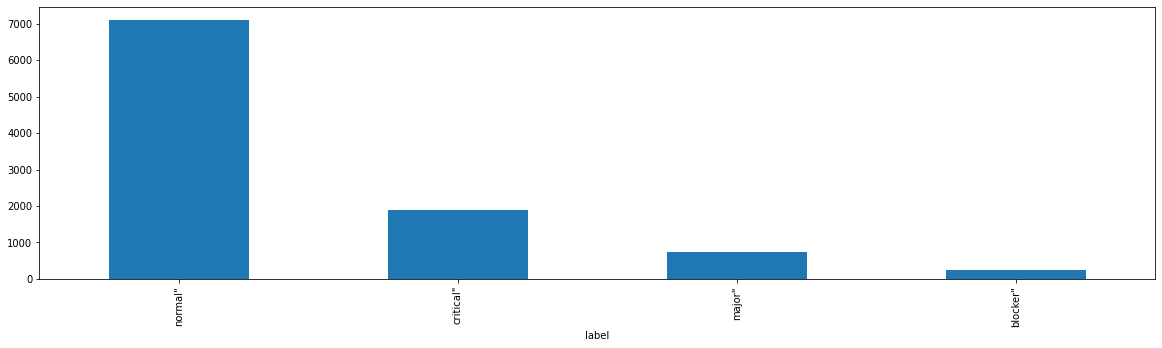

In [ ]:
df_train_dev.groupby('label').size().sort_values(ascending = False).plot.bar(figsize=(20, 5))

In [ ]:
df_train_dev.groupby('label').size().sort_values(ascending = False)

label
normal"      7105
critical"    1875
major"        748
blocker"      246
dtype: int64

# Process labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
le_fitted = LabelEncoder().fit(df_train_dev['label'])

In [ ]:
# map all classes that are not in train_dev to undefined
for i, label in enumerate(df_test['label']):
    df_test['label'][i] = 'und' if label not in le_fitted.classes_ else label
# check if it worked: should return an empty list
print([label for label in df_test['label'] if label not in set(df_train_dev['label'])])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

[]


In [ ]:
df_train_dev['label'][:10]

KeyError: ignored

In [ ]:
y_train_dev, y_test = le_fitted.transform(df_train_dev['label']), le_fitted.transform(df_test['label'])

# Preprocess bugs

Pipeline classes:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


class TweetNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self 

    def _normalize_tweet(self, tweet):
        """Remove punctuation and newlines, lowercase, pad with spaces.

        :param tweet: string
        :return: normalized string
        """
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
        tweet = re.sub(r'\n', r'', tweet)
        tweet = tweet.lower()
        tweet = re.sub(r'@\w+\b', r'', tweet)
        tweet = re.sub(r'\b\S+//\S+\b', r'', tweet)
        # tweet = ' ' + tweet + ' '
        return tweet
    
    def transform(self, X, y=None):
        tweets = []
        for tweet in X:
            tweets.append(self._normalize_tweet(tweet))
        return np.array(tweets)


class FeatureExtractor(BaseEstimator, TransformerMixin):


    vowels = set([c for c in 'aeiouäöüàéèëï'])
    consonants = set([c for c in 'bcdfghklmnlpqrstvwxyz'])

    def __init__(self):
        self.scaler = MinMaxScaler()

    def _to_bigrams(self, tweet):
        return [bg[0] + bg[1] for bg in zip(tweet, tweet[1:])]

    def _get_vowel_consonant_ratio(self, tweet):
        vf = 0
        cf = 0
        for c in tweet.lower():
            if c in self.vowels:
                vf =+ 1
            elif c in self.consonants:
                cf += 1
        return vf / (cf + 1)

    def _get_capitalization_ratio(self, tweet):
        up_count = 0
        for c in tweet:
            if c.upper() == c:
                up_count += 1
        return up_count / (len(tweet) + 1)

    def _get_double_char_freq(self, tweet):
        double_freq = 0
        for bg in self._to_bigrams(tweet):
            if bg[0] == bg[1]:
                double_freq += 1
        return double_freq
    
    def _extract_num_features(self, tweets):
        num_features = []
        for tweet in tweets:
            feat_tweet = []
            feat_tweet.append(self._get_vowel_consonant_ratio(tweet))
            feat_tweet.append(self._get_capitalization_ratio(tweet))
            feat_tweet.append(self._get_double_char_freq(tweet))
            num_features.append(feat_tweet)
        return np.array(num_features)
    
    def fit(self, X, y=None):
        numerical_features = self._extract_num_features(X)
        self.scaler.fit(numerical_features)
        return self
    
    def transform(self, X, y=None):
        numerical_features= self._extract_num_features(X)
        return X, self.scaler.transform(numerical_features)


class MatrixToArrayConverter1(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[0].toarray(), X[1]


class MatrixUnifier(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.concatenate([X[0].todense(), X[1]], axis=1)


class CountVectorizerWrapper:

    def __init__(self, ngram_range, analyzer, max_features, binary):
        print('args:', str([ngram_range, analyzer, max_features, binary]))
        self.countvec = CountVectorizer(ngram_range=ngram_range, analyzer=analyzer, max_features=max_features, binary=binary)
    
    def fit(self, X, y=None):
        tweets, numerical_features = X
        self.countvec.fit(tweets)
        return self
    
    def transform(self, X, y=None):
        tweets, numerical_features = X
        return self.countvec.transform(tweets), numerical_features


class OneHotEncoderWrapper:

    def __init__(self, handle_unknown):
        self.ohe = OneHotEncoder(handle_unknown=handle_unknown)
    
    def fit(self, X, y=None):
        self.ohe.fit(X[0])
        return self
    
    def transform(self, X, y=None):
        return self.ohe.transform(X[0]), X[1]


Helper classes for the pipeline:

In [ ]:
class GenericClassifier(BaseEstimator):

    def __init__(self, estimator):
        self.clf = clf


    def fit(self, X, y=None, **kwargs):
        self.clf.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.clf.predict(X)


    def predict_proba(self, X):
        return self.clf.predict_proba(X)


    def score(self, X, y):
        return self.clf.score(X, y)


class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        import pdb; pdb.set_trace()
        return X

    def fit(self, X, y=None, **fit_params):
        return self

# GridSearch and Training

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [ ]:
clf_param_grid = {
    'MultinomialNB': [MultinomialNB, {'CLF__alpha': [0.1, 1]}],
    'SGDClassifier': [SGDClassifier, {'CLF__loss': ['hinge', 'log'], 'CLF__penalty': ['l2', 'l1'], 'CLF__max_iter': [100, 300], 'CLF__early_stopping': [True, False]}]
}

In [ ]:
models = []
for clf_name in clf_param_grid:
    print(30*'-')
    print(clf_name)
    param_grid = clf_param_grid[clf_name][1]
    print(param_grid)
    bigram_vec_args = dict(ngram_range=(2,2), analyzer='char_wb', max_features=100, binary=True)
    pipe = Pipeline(steps=[
        ('TweetNormalizer', TweetNormalizer()),
        ('FeatureExtractor', FeatureExtractor()),
        ('BigramVectorizer', CountVectorizerWrapper(**bigram_vec_args)),
        ('MatrixToArrayConverter', MatrixToArrayConverter1()),
        ('OneHotEncoder', OneHotEncoderWrapper(handle_unknown='ignore')),
        ('MatrixUnifier', MatrixUnifier()),
        ('CLF', clf_param_grid[clf_name][0]())
    ], verbose=True)
    grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid, scoring='f1_micro', cv=10)
    grid.fit(df_train_dev['bug'].to_numpy(), y_train_dev)
    models.append(grid)

------------------------------
MultinomialNB
{'CLF__alpha': [0.1, 1]}
args: [(2, 2), 'char_wb', 100, True]
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.5s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   0.0s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Pr

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.1s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.2s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.1s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.1s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.1s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.2s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.2s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.1s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.2s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.1s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   2.2s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.8s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.8s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.7s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.5s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.6s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.8s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.6s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.8s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.7s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.7s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.5s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[Pipeline] ............... (step 7 of 7) Processing CLF, total=   1.8s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0s
[Pipeline] ............... (step 7 of 7) Processing CLF, total=   3.3s
[Pipeline] ... (step 1 of 7) Processing TweetNormalizer, total=   0.1s
[Pipeline] .. (step 2 of 7) Processing FeatureExtractor, total=   0.4s
[Pipeline] .. (step 3 of 7) Processing BigramVectorizer, total=   0.6s
[Pipeline]  (step 4 of 7) Processing MatrixToArrayConverter, total=   0.0s
[Pipeline] ..... (step 5 of 7) Processing OneHotEncoder, total=   0.1s
[Pipeline] ..... (step 6 of 7) Processing MatrixUnifier, total=   0.0

# Results

Micro f1-Score of the naive base models on the dev set:

In [ ]:
models[0].cv_results_

{'mean_fit_time': array([1.12249234, 1.1144706 ]),
 'mean_score_time': array([0.12933674, 0.12165906]),
 'mean_test_score': array([0.72385714, 0.72357143]),
 'param_CLF__alpha': masked_array(data=[0.1, 1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'CLF__alpha': 0.1}, {'CLF__alpha': 1}],
 'rank_test_score': array([1, 2], dtype=int32),
 'split0_test_score': array([0.72714286, 0.72714286]),
 'split1_test_score': array([0.72142857, 0.72142857]),
 'split2_test_score': array([0.7       , 0.70142857]),
 'split3_test_score': array([0.71571429, 0.71571429]),
 'split4_test_score': array([0.72857143, 0.72857143]),
 'split5_test_score': array([0.73285714, 0.73285714]),
 'split6_test_score': array([0.71714286, 0.71714286]),
 'split7_test_score': array([0.71714286, 0.71714286]),
 'split8_test_score': array([0.73857143, 0.73714286]),
 'split9_test_score': array([0.74      , 0.73714286]),
 'std_fit_time': array([0.02722769, 0.01921792]),
 'std_

Micro and macro f1-score of the best naive bayes model on the test set:

In [ ]:
from sklearn.metrics import f1_score
preds = models[0].predict(df_test['bug'].to_numpy())
f1_micro = f1_score(preds, y_test, average='micro')
f1_macro = f1_score(preds, y_test, average='macro')
print(f'F1-micro-score on the testset: {f1_micro}')
print(f'F1-macro-score on the testset: {f1_macro}')

F1-micro-score on the testset: 0.8809683927370545
F1-macro-score on the testset: 0.23417947801215588


Micro f1-Score of the SGD models on the dev set:

In [ ]:
models[1].cv_results_

{'mean_fit_time': array([1.3469048 , 1.56157084, 1.33405526, 1.59170597, 1.4405201 ,
        1.72794034, 1.44879322, 1.713466  , 2.22032859, 3.28094015,
        2.58390758, 3.05967634, 2.83111517, 4.57194583, 3.0159354 ,
        4.27098441]),
 'mean_score_time': array([0.12111337, 0.12070925, 0.12135096, 0.12362285, 0.12067373,
        0.12134085, 0.12401848, 0.12226448, 0.06814857, 0.06908364,
        0.06998861, 0.0694267 , 0.06960695, 0.0790782 , 0.06847961,
        0.06860471]),
 'mean_test_score': array([0.65785714, 0.67328571, 0.67057143, 0.69542857, 0.65142857,
        0.65142857, 0.63114286, 0.61928571, 0.72014286, 0.69928571,
        0.71814286, 0.69571429, 0.713     , 0.72585714, 0.71357143,
        0.71228571]),
 'param_CLF__early_stopping': masked_array(data=[True, True, True, True, True, True, True, True, False,
                    False, False, False, False, False, False, False],
              mask=[False, False, False, False, False, False, False, False,
                 

Accuracy of the best SGD model on the test set:

In [ ]:
preds = models[1].predict(df_test['bug'].to_numpy())
f1_micro = f1_score(preds, y_test, average='micro')
f1_macro = f1_score(preds, y_test, average='macro')
print(f'F1-micro-score on the testset: {f1_micro}')
print(f'F1-macro-score on the testset: {f1_macro}')

F1-micro-score on the testset: 0.9435104236718225
F1-macro-score on the testset: 0.24273356401384086


Let's check the confusion matrix:

In [ ]:
num_classes = len(le_fitted.classes_)
def create_confusion_matrix(num_classes, preds, y_test):
    """Create confusion matrix 'by hand' since test set does not contain all labels (thanks to Sarah Kiener)."""
    df = pd.DataFrame(np.zeros((num_classes, num_classes), dtype=int))
    for i, j in zip(preds, y_test):
        df.iloc[i, j] += 1
    df.columns = le_fitted.classes_
    df.index = le_fitted.classes_
    return df
df = create_confusion_matrix(num_classes, preds, y_test)
df

,"blocker""","critical""","major""","normal"""
"blocker""",0,0,0,1
"critical""",0,0,0,144
"major""",0,0,0,23
"normal""",0,0,0,2806
